<a href="https://colab.research.google.com/github/kalycoding/Facial-Recogntion-using-Huawei-Cloud/blob/main/facemaskChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import shutil
import PIL
import PIL.Image
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import tensorflow_hub as hub

In [ ]:
with open('/content/train_labels (1).csv') as data:
  raw_data = csv.reader(data)

  for raw in raw_data:
    if raw[0] in os.listdir('/content/images') and raw[-1] == '1':
      shutil.move((os.path.join('/content/images', raw[0])),'/content/train_data/facemask')
    if raw[0] in os.listdir('/content/images') and raw[-1] == '0':
      shutil.move((os.path.join('/content/images', raw[0])),'/content/train_data/nofacemask')
    

In [ ]:
for i in os.listdir('/content/images'):
  shutil.move((os.path.join('/content/images', i)),'/content/test')

In [ ]:
for f in os.listdir(os.path.join('/content/train_data', 'facemask'))[531:]:
 shutil.move(os.path.join('/content/train_data', 'facemask', f), '/content/test_data/facemask')

In [ ]:
print('train datafacemask images: {}'.format(len(os.listdir('/content/train_data/1'))))
print('train datafacemask images: {}'.format(len(os.listdir('/content/train_data/0'))))
print('test data facemask images: {}'.format(len(os.listdir('/content/test_data/1'))))
print('test data facemask images: {}'.format(len(os.listdir('/content/test_data/0'))))
print('testing dataset: {}'.format(len(os.listdir('/content/test'))))

train datafacemask images: 531
train datafacemask images: 531
test data facemask images: 114
test data facemask images: 133
testing dataset: 509


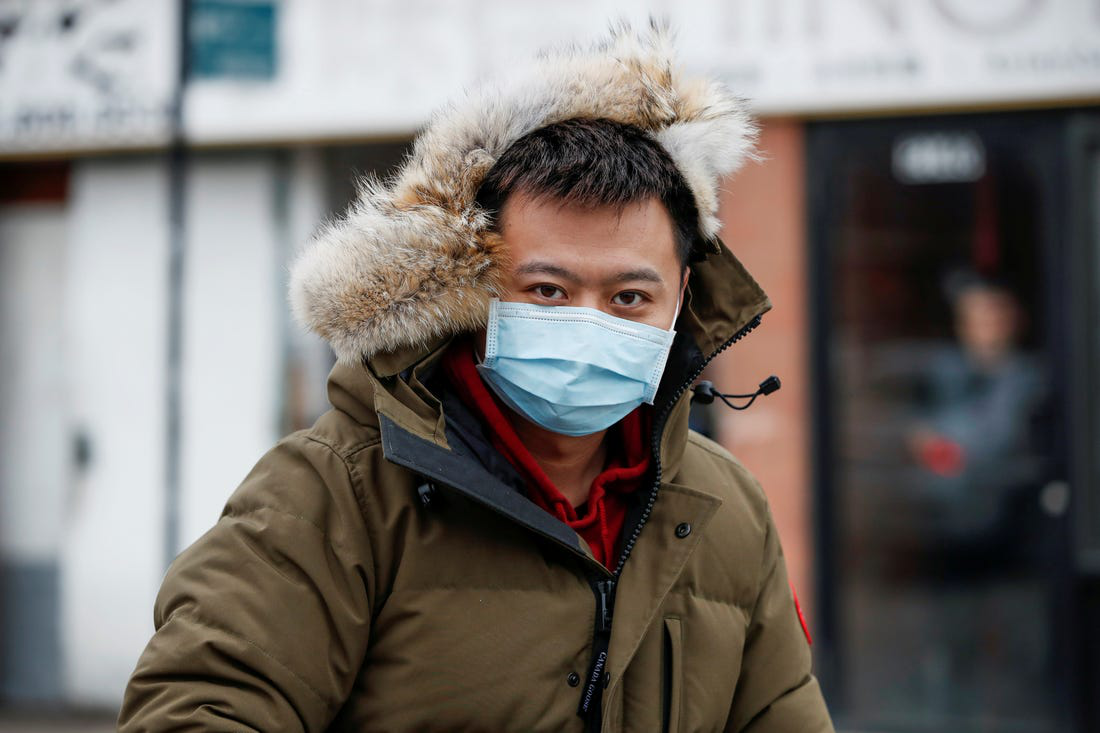

In [ ]:
PIL.Image.open('/content/test/dhxbbarhojjiuoacxyzdtayykriavi.jpg')

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-12-01 19:28:22--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  88.1MB/s    in 1.0s    

2020-12-01 19:28:23 (88.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = tf.keras.Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train_data', # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        '/content/test_data',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1062 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      #steps_per_epoch=65,
      epochs=2,
      validation_data=validation_generator,
      #validation_steps=50,
      #verbose=2
      )

Epoch 1/2
54/54 [==============================] - 77s 1s/step - loss: 0.3238 - acc: 0.8691 - val_loss: 0.4150 - val_acc: 0.8740
Epoch 2/2
54/54 [==============================] - 77s 1s/step - loss: 0.3431 - acc: 0.8719 - val_loss: 0.4312 - val_acc: 0.8659


In [ ]:
model.evaluate_generator(validation_generator)

[0.43123868107795715, 0.8658536672592163]

In [ ]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      #steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      #validation_steps=50,
      #verbose=2
      )

Epoch 1/50
54/54 [==============================] - 88s 2s/step - loss: 0.3489 - acc: 0.8286 - val_loss: 0.3772 - val_acc: 0.8699
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.3493 - acc: 0.8427 - val_loss: 0.3584 - val_acc: 0.8699
Epoch 3/50
54/54 [==============================] - 87s 2s/step - loss: 0.3464 - acc: 0.8437 - val_loss: 0.3524 - val_acc: 0.8618
Epoch 4/50
54/54 [==============================] - 87s 2s/step - loss: 0.3316 - acc: 0.8635 - val_loss: 0.3498 - val_acc: 0.8618
Epoch 5/50
54/54 [==============================] - 91s 2s/step - loss: 0.3282 - acc: 0.8559 - val_loss: 0.3489 - val_acc: 0.8577
Epoch 6/50
54/54 [==============================] - 87s 2s/step - loss: 0.3260 - acc: 0.8635 - val_loss: 0.3471 - val_acc: 0.8618
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.3308 - acc: 0.8569 - val_loss: 0.3490 - val_acc: 0.8577
Epoch 8/50
54/54 [==============================] - 87s 2s/step - loss: 0.3085 - acc: 0.86

KeyboardInterrupt: ignored

In [ ]:
test_data = os.listdir('/content/test')

predict_data = [i for i in test_data]

In [ ]:
predictions = []
for pre in predict_data:
  img = tf.keras.preprocessing.image.load_img(
    os.path.join('/content/test', pre), target_size=(img_height, img_width)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  img_array = img_array / 255.0

  prediction = model.predict(img_array)
  predictions.append(prediction[0][0])

In [ ]:
submit = pd.DataFrame(columns=['id', 'label'])
submit['id'] = predict_data
submit['label'] = predictions
submit.to_csv('transfer.csv', index=False)